# Residual Attention Network 128 on Cifar 100

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time, os, datetime
import PIL
import pandas as pd
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from tensorflow.keras.datasets import cifar10,cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,TensorBoard, LearningRateScheduler
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input,BatchNormalization,Conv2D,MaxPooling2D,Activation,AveragePooling2D,Flatten,Dropout,Dense

In [3]:
print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)

TF version:  2.2.0
Keras version: 2.3.0-tf


## Load CIFAR-100 Data

In [4]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [5]:
# devide into training & validation sets
n_validation = 10000

x_val   = x_train[-n_validation:]
y_val   = y_train[-n_validation:]
x_train = x_train[:-n_validation]
y_train = y_train[:-n_validation]

# Convert to binary class matrix
y_val   = to_categorical(y_val,   num_classes=100)
y_train = to_categorical(y_train, num_classes=100)
y_test  = to_categorical(y_test,  num_classes=100)


print('Training:   ',x_train.shape,y_train.shape)
print('Validation: ',x_val.shape,y_val.shape)
print('Test:       ',x_test.shape,y_test.shape)

Training:    (40000, 32, 32, 3) (40000, 100)
Validation:  (10000, 32, 32, 3) (10000, 100)
Test:        (10000, 32, 32, 3) (10000, 100)


## Data Augmentation

In [6]:
# define generators for training, validation, and test sets
train_datagen = ImageDataGenerator(width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   zoom_range = 0.1,
                                   rotation_range=20,
                                   shear_range = 0.1,
                                   rescale=1./255,
#                                    brightness_range=(0.7, 1.1),
#                                    vertical_flip = True,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)


val_datagen = ImageDataGenerator(rescale=1./255, 
                                 featurewise_center=True,
                                 featurewise_std_normalization=True)

test_datagen = ImageDataGenerator(rescale=1./255,
                                  featurewise_center=True,
                                  featurewise_std_normalization=True)

# compute quantities required for feature normalization
train_datagen.fit(x_train)
val_datagen.fit(x_val)
test_datagen.fit(x_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


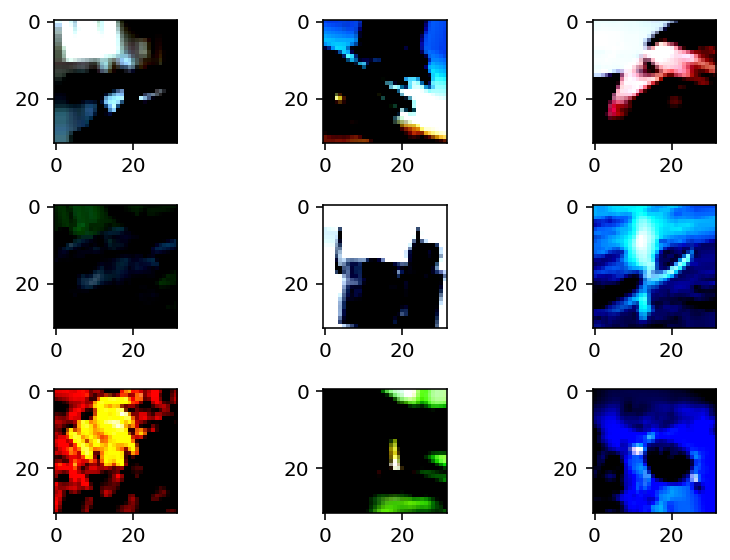

In [7]:
for x_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=9,seed=3019):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i])
    plt.tight_layout()
    break

## Define & Train the model

In [8]:
from utils.models import AttentionResNet128

In [9]:
# define and compile model
model = AttentionResNet128(shape=(32,32,3), in_channel=32, kernel_size=5, n_classes=100, regularization=0.01)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
# model.summary()

In [10]:
start = time.time()

batch_size = 32
epochs     = 150

# callbacks (Reference: https://github.com/qubvel/residual_attention_network/blob/master/train_cifar10.ipynb)
lr_reducer    = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=7, min_lr=10e-7, epsilon=0.01, verbose=1)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1)


H = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs           = epochs,
                        steps_per_epoch  = len(x_train) // batch_size,
                        validation_data  = val_datagen.flow(x_val, y_val, batch_size=batch_size),
                        callbacks        = [lr_reducer, early_stopper])

end = time.time()
print("Total training time: {}.".format((end-start)/60))


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
1250/1250 [==============================] - 542s 434ms/step - loss: 5.9555 - accuracy: 0.0869 - val_loss: 5.2789 - val_accuracy: 0.1215 - lr: 1.0000e-04
Epoch 2/150
1250/1250 [==============================] - 538s 430ms/step - loss: 4.7357 - accuracy: 0.1602 - val_loss: 4.4115 - val_accuracy: 0.1930 - lr: 1.0000e-04
Epoch 3/150
1250/1250 [==============================] - 537s 430ms/step - loss: 4.0745 - accuracy: 0.2023 - val_loss: 3.8641 - val_accuracy: 0.2192 - lr: 1.0000e-04
Epoch 4/150
1250/1250 [==============================] - 538s 430ms/step - loss: 3.6087 - accuracy: 0.2369 - val_loss: 3.6224 - val_accuracy: 0.2437 - lr: 1.0000e-04
Epoch 5/150
1250/1250 [==============================] - 538s 430ms/step - loss: 3.2926 - accuracy: 0.2683 - val_loss: 3.1304 - val_accuracy: 0.3008 - lr: 1.0000e-04
Epoch 6/150
1250/1250 [==============================] - 538s 430ms/step - loss: 3.0673 - accu

## Save model & plot training process

In [11]:
model_name = 'AttentionResNet128_cifar100'
model.save("./Models/"+model_name+".hdf5")

In [12]:
def plot_training(H, model_name):
    acc     = H.history['accuracy']
    val_acc = H.history['val_accuracy']
    loss    = H.history['loss']
    val_loss= H.history['val_loss']

    epochs = range(len(acc))

    fig, axes = plt.subplots(figsize=(10,4),ncols=2)

    axes[0].plot(epochs, acc, 'b',label='Train')
    axes[0].plot(epochs, val_acc, 'r',label='Validation')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend()


    axes[1].plot(epochs, loss, 'b')
    axes[1].plot(epochs, val_loss, 'r')
    axes[1].set_title('Training and validation loss')
    
    plt.tight_layout()
    plt.rcParams['savefig.dpi'] = 220
    plt.savefig('./Figures/TrainingProcess_'+model_name+'.png')
    
    # save the metrics of training process to a csv file
    hist_df = pd.DataFrame(H.history) 
    hist_df.to_csv('./Models/'+model_name+'_history.csv')

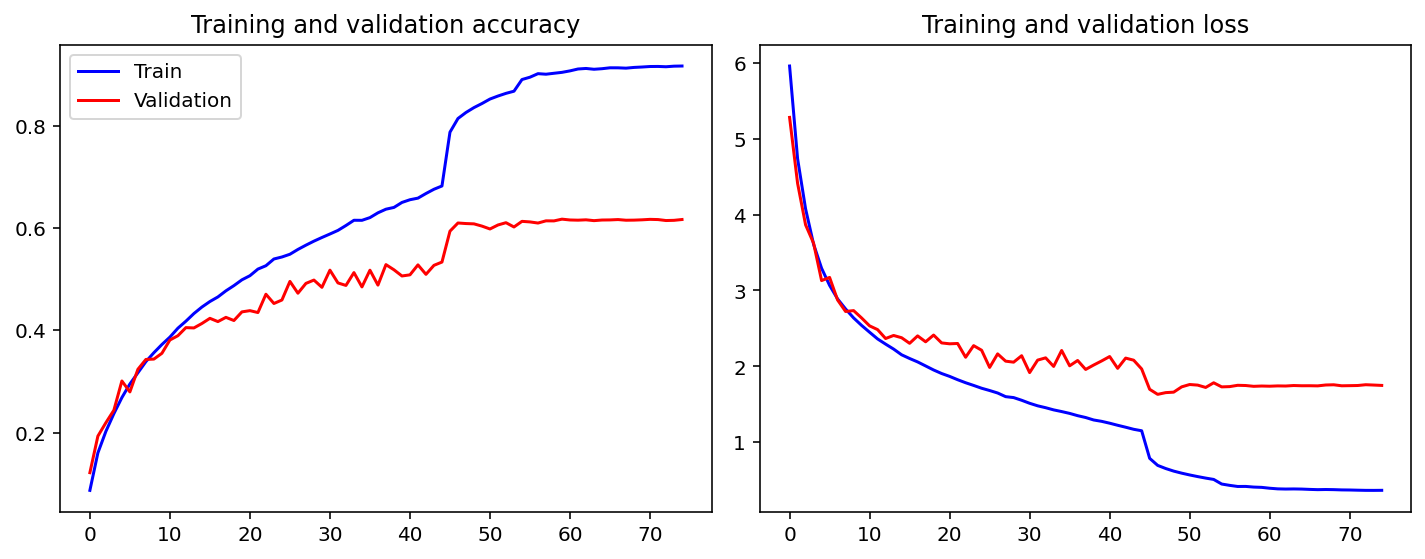

In [13]:
plot_training(H,model_name)

## Evaluation on the test set

In [14]:
test_result = model.evaluate_generator(test_datagen.flow(x_test, y_test), 
                                       steps=len(x_test)/batch_size, 
                                       use_multiprocessing=True)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [15]:
test_result

[1.7263234853744507, 0.616599977016449]